# Library

In [51]:
# My library
from molgraph.dataset import *
from molgraph.graphmodel import *
from molgraph.training import *
from molgraph.testing import *
from molgraph.visualize import *
from molgraph.experiment import *
# General library
import argparse
import numpy as np
# pytorch
import torch
import pytorch_lightning as pl

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# Argument

In [52]:
parser = ArgumentParser()
args = parser.getArgument('''
--file bbbp
--model GIN
--schema AR_0
--reduced junctiontree
--vocab_len 100
--mol_embedding 256
--batch_normalize
--fold 5
'''.split())

# Dataset

In [53]:
file = args.file
smiles = args.smiles 
task = args.task
splitting = args.splitting 
splitting_fold = args.fold
splitting_seed = args.splitting_seed

# get validated dataset
datasets = getDataset(file, smiles, task, splitting)
# compute positive weight for classification
if args.graphtask == 'classification':
    args.pos_weight = getPosWeight(datasets)
    print('pos_weight:', args.pos_weight)
# generate dataset splitting
datasets_splitted = generateDatasetSplitting(file, splitting, splitting_fold, splitting_seed)
# generate all graph dataset
datasets_graph = generateGraphDataset(file)
# generate all reduced graph dataset
dict_reducedgraph = dict()
for g in args.reduced:
    if g == 'substructure':
        for i in range(splitting_fold):
            vocab_file = file+'_'+str(i)
            if not os.path.exists('vocab/'+vocab_file+'.txt'):
                generateVocabTrain(file, splitting_seed, splitting_fold, vocab_len=args.vocab_len)
            dict_reducedgraph[g] = generateReducedGraphDict(file, g, vocab_file=vocab_file)
    else:
        dict_reducedgraph[g] = generateReducedGraphDict(file, g)

Function: getDataset()
number of valid smiles: 3949
Function: generateDatasetSplitting()
Fold: 5
Fold Number: 0
-- Datasets Train: 2844
-- Datasets Val: 710
-- Datasets Test:  395
-- Total: 3949
Fold Number: 1
-- Datasets Train: 2843
-- Datasets Val: 711
-- Datasets Test:  395
-- Total: 3949
Fold Number: 2
-- Datasets Train: 2843
-- Datasets Val: 711
-- Datasets Test:  395
-- Total: 3949
Fold Number: 3
-- Datasets Train: 2843
-- Datasets Val: 711
-- Datasets Test:  395
-- Total: 3949
Fold Number: 4
-- Datasets Train: 2843
-- Datasets Val: 711
-- Datasets Test:  395
-- Total: 3949
Function: generateGraphDataset()
Datasets graph:  3949


# Test

In [55]:
import os
args_test = dict()

# Load model
ts = "2023-May-16-15:43:57"
reduced_list = '_'.join(args.reduced)
args_test['log_folder_name'] = os.path.join(*[args.file, args.model+'_'+args.schema+'_'+reduced_list, f"{ts}"])
args_test['exp_name'] = args.experiment_number
args_test['fold_number'] = 3
args_test['seed'] = args.seed

# test dataset original
test_loader, datasets_test =  generateDataLoaderTesting(args.file, args.batch_size)

# test dataset external
# test_external = 'test_external_full.csv'
# datasets_test_df = pd.read_csv('dataset/'+args.file+'/'+test_external)
# datasets_test_list = []
# for idx, row in datasets_test_df.iterrows():
#     smiles_processes = mol_to_smiles(smiles_to_mol(row['X'], with_atom_index=False))
#     d = constructGraph(smiles_processes, row['y'])
#     datasets_test_list.append(d)
# test_loader, datasets_test =  generateDataLoaderListing(datasets_test_list, 16)

In [56]:
training_bin = torch.load('./dataset/'+args_test['log_folder_name']+'/checkpoints/training_args.bin')

args.batch_size = training_bin.batch_size
args.num_layers = training_bin.num_layers
args.num_layers_reduced = training_bin.num_layers_reduced
args.in_channels = training_bin.in_channels
args.hidden_channels = training_bin.hidden_channels
args.out_channels = training_bin.out_channels
args.edge_dim = training_bin.edge_dim
args.num_layers_self = training_bin.num_layers_self
args.num_layers_self_reduced = training_bin.num_layers_self_reduced
args.dropout = training_bin.dropout
args.lr =  training_bin.lr
args.weight_decay = training_bin.weight_decay

args

Namespace(batch_normalize=True, batch_size=16, class_number=1, device=device(type='cpu'), dropout=0.4, edge_dim=32, experiment_number='001', file='l08_aromaticity', fold=5, gpu=-1, grad_norm=1.0, graphtask='regression', heads=1, hidden_channels=256, in_channels=256, lr=5e-05, lr_schedule=True, model='GIN', mol_embedding=256, num_epochs=300, num_layers=2, num_layers_reduced=2, num_layers_self=2, num_layers_self_reduced=2, out_channels=256, patience=30, reduced=['junctiontree'], schema='AR_0', seed=42, smiles='SMILES', splitting='split', splitting_seed=42, task='aromatic_count', vocab_len=100, weight_decay=5e-05)

GNN_Combine(
  (node_feature_graph): NodeLinear(
    (lin1): Linear(in_features=79, out_features=256, bias=True)
    (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (edge_feature_graph): EdgeLinear(
    (lin1): Linear(in_features=10, out_features=32, bias=True)
    (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (GNN_Graph): GNN_Graph(
    (convs): ModuleList(
      (0): GINEConv(nn=Sequential(
        (0): GIN_Sequential(
          (lin1): Linear(in_features=256, out_features=256, bias=True)
          (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (leakyrelu1): LeakyReLU(negative_slope=0.01)
          (lin2): Linear(in_features=256, out_features=256, bias=True)
        )
      ))
      (1): GINEConv(nn=Sequential(
        (0): GIN_Sequential(
          (lin1): Linear(in_features=256, out_features=256, bias=True)
          (bn1): BatchNorm1d(256, e

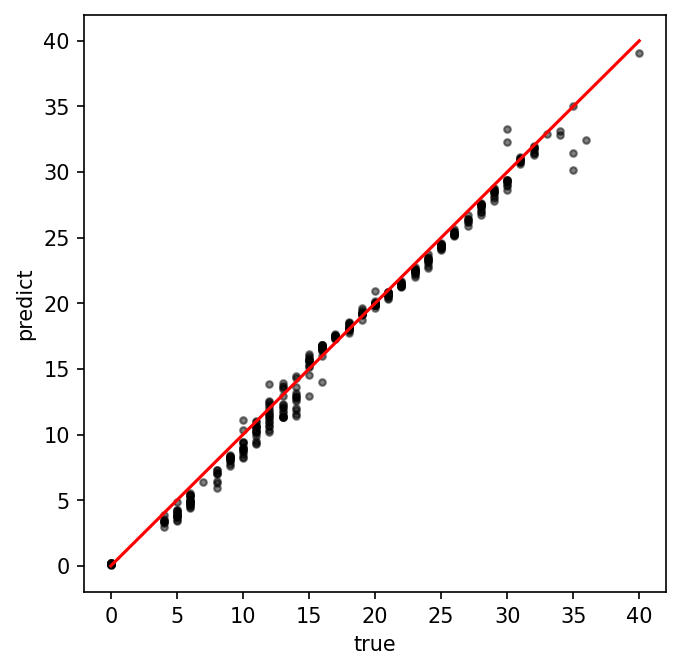

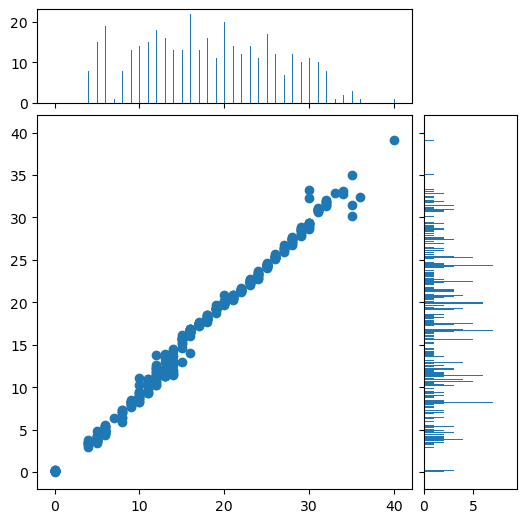

In [57]:
tester = Tester(args, args_test)
tester.test(test_loader)

In [58]:
# # ECFP
# from rdkit.Chem import AllChem
# fingerprint = list()
# test_y = list()

# for t in test_loader:
#     for i, s in enumerate(t.smiles):
#         mol = smiles_to_mol(s)
#         morgan = AllChem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=2048)
#         fingerprint.append(np.array(morgan))
#         test_y.append(np.array(t.y[i])[0])

In [59]:
x_embed = tester.getXEmbed()
y_test = tester.getYTest()
# x_embed = np.array(fingerprint)
# y_test = np.array(test_y)

In [60]:
from sklearn.metrics import silhouette_score
# The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. 
# Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.
silhouette_score(x_embed, y_test)

-0.1359387447798321

In [62]:
path = 'dataset/'+args_test['log_folder_name']+'/results/test'
if not(os.path.isdir(path)):
    os.makedirs(path)

if args.graphtask == 'regression':
    y_test, legend = getLegend(args.graphtask, y_test)
else:
    legend = None

[0.73306927 0.10111438]
[717.52976506 266.48568587]


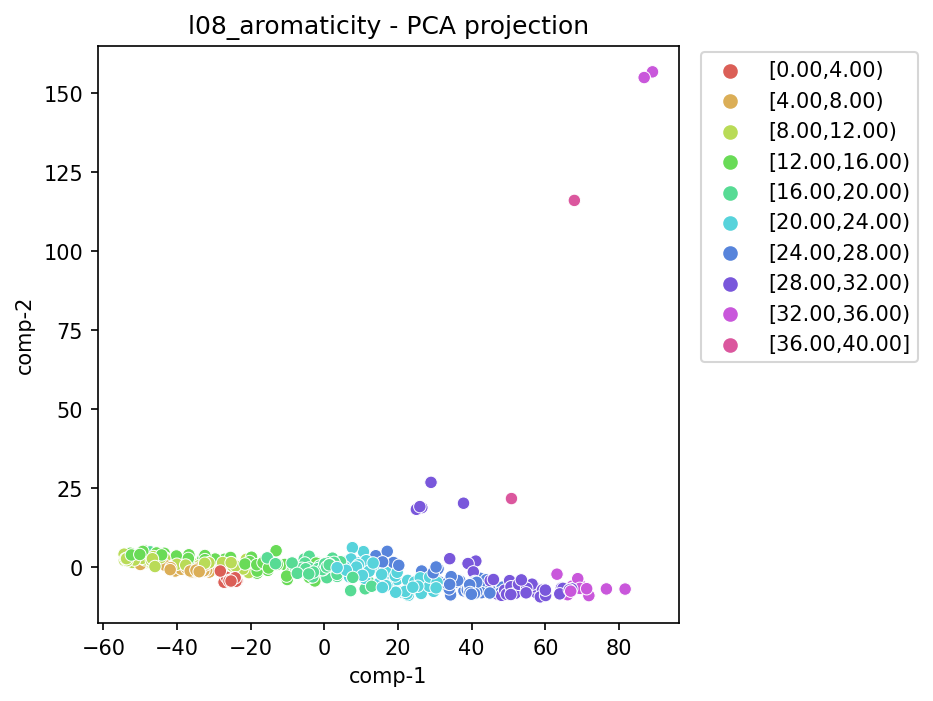

In [63]:
visualize_pca(x_embed, y_test, title=args.file, path=path, legend=legend)

# TSNE

/opt/anaconda3/envs/moleculegraph38/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/envs/moleculegraph38/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 395 samples in 0.000s...
[t-SNE] Computed neighbors for 395 samples in 0.019s...
[t-SNE] Computed conditional probabilities for sample 395 / 395
[t-SNE] Mean sigma: 6.653116
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.981762
[t-SNE] KL divergence after 1000 iterations: 0.237603


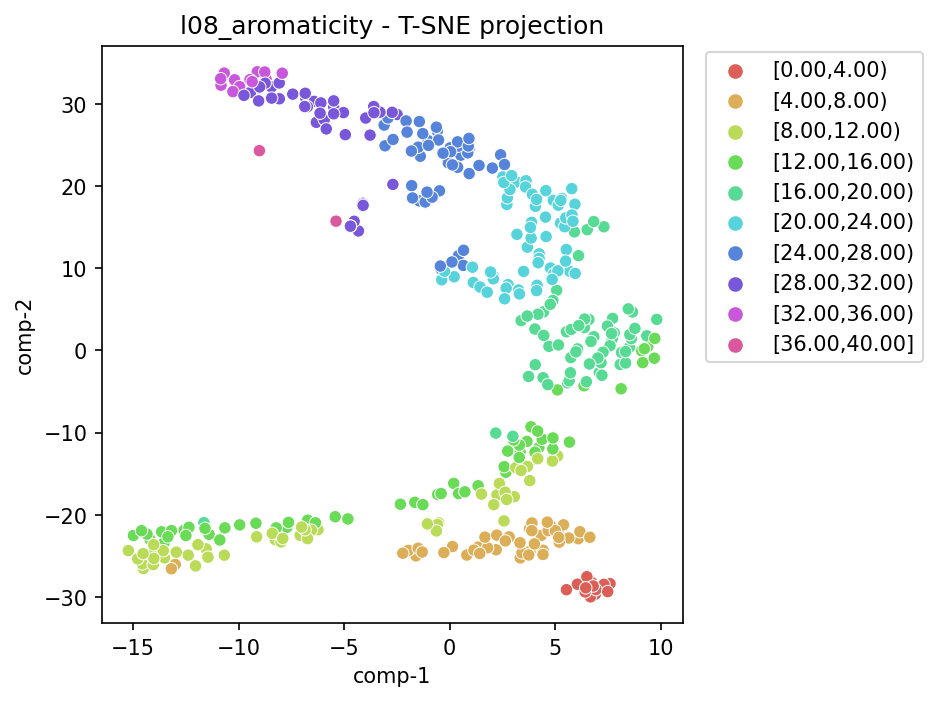

In [64]:
visaulize_tsne(x_embed, y_test, title=args.file, path=path, legend=legend)

In [20]:
# visualize_umap(x_embed, y_test, title=args.file)

# Test All Folds

In [22]:
import os

pref_all = list()

for fold in range(5):
    args_test = dict()

    # Load model
    ts = "2023-Apr-11-12:35:46"
    reduced_list = '_'.join(args.reduced)
    args_test['log_folder_name'] = os.path.join(*[args.file, args.model+'_'+args.schema+'_'+reduced_list, f"{ts}"])
    args_test['exp_name'] = args.experiment_number
    args_test['fold_number'] = fold
    args_test['seed'] = args.seed

    # test dataset original
    test_loader, datasets_test =  generateDataLoaderTesting(args.file, args.batch_size)

    # test dataset external
    # test_external = 'test_external_full.csv'
    # datasets_test_df = pd.read_csv('dataset/'+args.file+'/'+test_external)
    # datasets_test_list = []
    # for idx, row in datasets_test_df.iterrows():
    #     smiles_processes = mol_to_smiles(smiles_to_mol(row['X'], with_atom_index=False))
    #     d = constructGraph(smiles_processes, row['y'])
    #     datasets_test_list.append(d)
    # test_loader, datasets_test =  generateDataLoaderListing(datasets_test_list, 16)

    training_bin = torch.load('./dataset/'+args_test['log_folder_name']+'/checkpoints/training_args.bin')

    args.batch_size = training_bin.batch_size
    args.num_layers = training_bin.num_layers
    args.num_layers_reduced = training_bin.num_layers_reduced
    args.in_channels = training_bin.in_channels
    args.hidden_channels = training_bin.hidden_channels
    args.out_channels = training_bin.out_channels
    args.edge_dim = training_bin.edge_dim
    args.num_layers_self = training_bin.num_layers_self
    args.num_layers_self_reduced = training_bin.num_layers_self_reduced
    args.dropout = training_bin.dropout
    args.lr =  training_bin.lr
    args.weight_decay = training_bin.weight_decay

    tester = Tester(args, args_test)
    tester.test(test_loader)

    perf = tester.performance_report
    pref_all.append(perf)

FileNotFoundError: [Errno 2] No such file or directory: './dataset/l08_aromaticity/GIN_A_/2023-Apr-11-12:35:46/checkpoints/training_args.bin'

## Performance

In [ ]:
print(pref_all[0].keys())
print('Average Performance')
for key in pref_all[0].keys():
    print(key, np.mean([x[key] for x in pref_all]))
    print("sd", np.std([x[key] for x in pref_all]))